# Active-learning tutorial: Preparing and evaluating committee MACE models for protonated water clusters

In this tutorial, we will be preparing and working a committee of MACE models (C-MACE?) to describe two different protonated water clusters in the gas phase 
and illustrate important aspects of committee-based active learning.

In the first part, we will leverage the accessible uncertainty measure to screen a wide pool of candidate geometries originating from a DFT simulation of the Zundel cation (H$_5$O$_2^+$) to create a robust and concise training data set.

In the second part, we will use the obtained model to perform an exploratory simulation of the related Eigen cation (H$_9$O$_3^+$) and, once again, rely on active learning to select the most relevant training structures
in order for the model to gain accuracy on a new, unexplored part of the configuration space.

## To Do 

- estimate how expensive things are - ideally we would be able to run trainings and simulations on the spot (more instructive)
- if we want to go from the cations to the liquid water/ice active learning, we can do no training or simulations on the spot and will have to prepare and provide everything ready-made
- fix E0 alignment to minimize committee disagreement
- default to multiprocesssing parallel training everywhere

## Import modules

This is all the modules and functions that we will need to run this tutorial.

In [1]:
import os, glob, re
import multiprocessing
from tqdm.notebook import tqdm
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ase.io import read, write # read and write structures

# import functions to run this tutorial
from myfunctions import train_mace     # train MACE model
from myfunctions import eval_mace      # evaluate MACE model
from myfunctions import extxyz2energy  # extract energy from extxyz file
from myfunctions import run_qbc        # run Query by Committee
from myfunctions import clean_output   # clean the output of the training

/home/stoccoel/programs/miniforge/envs/alt/lib/python3.9/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [2]:
plt.style.use('notebook.mplstyle')

# Part I

In the first part, we will tackle the Zundel cation (shown below) using a committee of MACE models.
To actively select structures for the training set, we need to perform **query by committee** (QbC) on a provided candidate set.

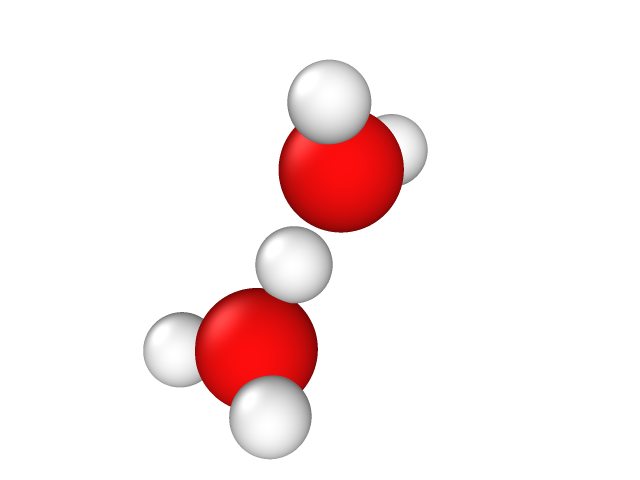

In [3]:
display(Image(filename='../initial-datasets/zundel/zundel.png'))

In [4]:
n_init_train = 20
n_test = 50  
n_committee = 4
parallel = True
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
n_iter_qbc = 5
n_add_iter = 20     

In [5]:
np.random.seed(0)
os.makedirs(f'{init_train_folder}', exist_ok=True)
os.makedirs(f'{init_train_folder}/config', exist_ok=True)
os.makedirs(f'{init_train_folder}/models', exist_ok=True)
os.makedirs(f'{init_train_folder}/eval', exist_ok=True)
os.makedirs(f'{init_train_folder}/structures', exist_ok=True)
os.makedirs(f'{md_folder}', exist_ok=True)

## Select initial training structures

The first step in QbC is to select a small number of random structures (here `n_init_train`) to train a very preliminary committee that can, however, already provide a measure of uncertainty.

We start by selecting these initial structures and, at the same time, separating out a small portion of our data points for testing purposes.

In [ ]:
# Read the all the structures from file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')
# view(structures)  # Opens an interactive GUI window to visualize the structures

In [ ]:
# Create the initial training and test sets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
remaining_candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

print(f'\nSelected indices for training: {indices_train}')
print(f'\nSelected indices for test: {indices_test}')

initial_training_set = [structures[i] for i in indices_train]
test_set = [structures[i] for i in indices_test]
remaining_structures = [structures[i] for i in remaining_candidate_idcs]

print(f"\nSaving the initial training set to 'structures/init.train.extxyz'")
write(f'{init_train_folder}/structures/init.train.extxyz', initial_training_set, format='extxyz')

print(f"\nSaving the test set to 'structures/test.extxyz'")
write(f'{init_train_folder}/structures/test.extxyz', test_set, format='extxyz')

print(f"\nSaving the remaining structures to 'structures/remaining.extxyz'")
write(f'{init_train_folder}/structures/remaining.extxyz', remaining_structures, format='extxyz')

## Initial Training

Now we get to the initial training of the committee.

Notice that we provide `structures/init.train.set.extxyz` as the training data set.

In [ ]:
# Define different values for each config
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{init_train_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 4
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# num radial basis: 4
# num cutoff basis: 3.0

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 20

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{init_train_folder}/models"
log_dir        : "{init_train_folder}/log"
checkpoints_dir: "{init_train_folder}/checkpoints"
results_dir    : "{init_train_folder}/results"
train_file     : "{init_train_folder}/structures/init.train.extxyz"

energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 10
E0s: "average" # to be fixed
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: False
"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

In [ ]:
# train a committee of MACE models
def train_single_model(n):
    train_mace(f"{init_train_folder}/config/config.{n}.yml")

if parallel: # parallel version: it should take around 25s 
    print(f"Training {n_committee} models in parallel")
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))
        
else: # serial version: it should take around 1m
    print(f"Training {n_committee} models in serial\n")
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)
        
for n in range(n_committee):
    os.remove(f"{init_train_folder}/models/mace.com={n}_compiled.model")
        
# clean_output(init_train_folder,n_committee)

## Evaluation of the committee disagreement on the remaining structures in our candidate pool

Now that we have our preliminary model, we will ask it to predict the energies on all remaining structures in the candidate pool that have not been selected into the training set yet.

That will allow us to evaluate two very important quantities.

The first is the **average committee prediction** 

$$
\overline{E}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} E_n(\mathbf{q}_i),
$$

which is an important quantity in committee based models because it typically a more accurate prediction and represents the potential energy surface on which MD is performed.

The second one is the **committee disagreement** which we define as the standard deviation of the energy predicitons

$$
\sigma_E(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{c}} \sum_{n}^{N_\mathrm{c}} \left[ E_n(\mathbf{q}_i) - \overline{E}(\mathbf{q}_i) \right]^2}.
$$

This quantity is the centerpiece of QbC.

It serves as an uncertainty measure: the more the committee members disagree, the less sure they are about what the correct output should actually be.

As such, the committee disagreement *correlates* with the actual error of prediction (*i.e.*, the generalization error) but it is important to remember that they are not the same quantity! We will come back to this shortly.

In [ ]:
# ToDo: put files somewhere else
for n in tqdm(range(n_committee)):
    eval_mace(f'{init_train_folder}/models/mace.com={n:d}.model',
              '../initial-datasets/zundel/train.extxyz',
              f'{init_train_folder}/eval/train_{n:02d}.extxyz')

In [ ]:
# read in predicted energies, evaluate average energies and disagreements
energies = np.array([extxyz2energy(f'{init_train_folder}/eval/train_{n:02d}.extxyz') for n in tqdm(range(n_committee))])
avg_energy = energies.mean(axis=0)
disagreement = energies.std(axis=0)

In [ ]:
plt.figure(figsize=(6, 3))
for n, e in enumerate(energies):
    plt.plot(e, label=rf'$E_{n:d}$', alpha=0.5,linewidth=0.5)
plt.plot(avg_energy, label=r'$\overline{E}$', color='k',linewidth=1)
plt.legend()
plt.xlabel('Data point index')
plt.ylabel('Energy [eV]')
plt.title('Energy prediction of the initial committee model')
plt.show()

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(disagreement,color="blue",linewidth=0.5)
plt.xlabel('Data point index')
plt.ylabel(r'$\sigma_E$ [eV]')
plt.title('Committee disagreement of the initial model')
plt.show()

# Select relevant training data via Query by Committee (QbC)

At this point, we have an initial committee model that can predict $\sigma_E$ for arbitrary data points from the remaining candidate pool.

With this ability in our hands, we can now proceed to the actual execution of the QbC procedure.

There one iteratively predicts $\sigma_E$ over the remaining candidate pool, selects a fixed number of candidate geometries that feature the **highest** $\sigma_E$ and adds them to the training set and retrains the committee.

Have a look at the function `run_qbc()` contained in the `myfunctions.py` file (it is stashed away because it is a bit wordy, but it exactly captures the idea of the previous sentence). 

## Open question

- Even with the gas phase Zundel, running the QbC on the spot on the available resources takes >10 minutes. Maybe we can consider just running it for a few iterations and then provide a finished model for use. 

In [ ]:
# Define different values for each config
# TODO: make this simpler - the only thing we need to change is the name of the training extxyz file.
os.makedirs(qbc_folder, exist_ok=True)
os.makedirs(f'{qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 4
max_L: 0            # take it larger but not smaller
max_ell: 1          # take it larger but not smaller
correlation: 1      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 20

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{qbc_folder}/models"
log_dir        : "{qbc_folder}/log"
checkpoints_dir: "{qbc_folder}/checkpoints"
results_dir    : "{qbc_folder}/results"

train_file: "{qbc_folder}/train-iter.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 10

E0s: "average" # to be fixed
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote qbc-work/config/config.0.yml
Wrote qbc-work/config/config.1.yml
Wrote qbc-work/config/config.2.yml
Wrote qbc-work/config/config.3.yml


In [7]:
# Attention: this function will not
# fns_committee = [f'{init_train_folder}/models/mace.n={n:d}.model' for n in range(n_committee)]
run_qbc(
    init_train_folder=init_train_folder,
    # fns_committee=fns_committee,                                       # list of MACE models
    fn_candidates=f'{init_train_folder}/structures/remaining.extxyz',  # candidate structures
    test_dataset=f'{init_train_folder}/structures/test.extxyz',        # test set
    n_iter=n_iter_qbc,                                                 # number of QbC iterations
    config=f'{qbc_folder}/config',                                     # folder with config files
    ofolder=qbc_folder,                                                # folder to save the QBC results
    n_add_iter=n_add_iter,                                             # number of structures to add in each iteration
    recalculate_selected=False,                                        # whether to recalculate the selected structures with DFT (part 2)
);
# it should take 13m

Starting QbC.
Number of models: 4
Number of iterations: 5
Number of new candidates at each iteration: 20
Candidates file: init-train/structures/remaining.extxyz
Test file: init-train/structures/test.extxyz

	--------------------------------------------------------------------
	Start of QbC iteration 1/5

	Started at: 2025-05-22 16:58:49
	Predicting committee disagreement across the candidate pool.
	Picking 20 new highest-disagreement data points.
	Retraining committee.

	Results of QbC iteration 1/5:
	               Disagreement (pool): 0.368990 eV
	           Disagreement (selected): 0.398533 eV
	                New training set size: 20
	               New candidate set size: 910

	End of QbC iteration 1/5
	Ended at:   2025-05-22 16:59:22
	Duration:   32.64 seconds

	--------------------------------------------------------------------
	Start of QbC iteration 2/5

	Started at: 2025-05-22 16:59:22
	Predicting committee disagreement across the candidate pool.
	Picking 20 new highest-dis

### Monitoring QbC convergence

How does one know when the QbC cycle has converged? Simply setting a threshold value for $\sigma_E$ is not the best idea since one does not *a priori* know what it should be.

A better way to look at it is to consider the QbC converged once all the *unlearned* information has been extracted from the candidate set and the committee is no longer learning anything new.

To visualize this, we can plot the evolution of $\sigma_E$ for each new added batch of structures and see how that comes closer to the value of $\sigma_E$ averaged over the candidate pool.

In practice one stops the QbC once those curves reach a plateau.

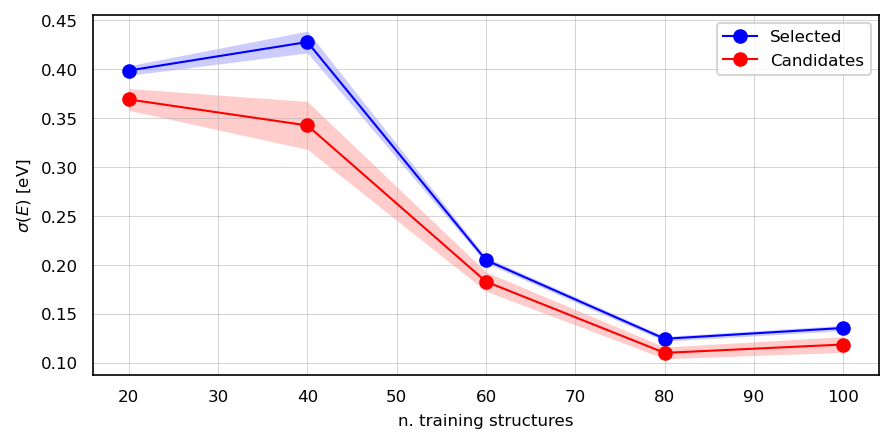

In [8]:
n_training_structures   = np.arange(n_init_train,n_iter_qbc*n_add_iter+n_init_train,n_add_iter)
sigma = np.loadtxt('qbc-work/disagreement.txt').T

fig, ax = plt.subplots(figsize=(6, 3))  # 1 row, 2 columns

# --- First plot: Selected ---
ax.plot(n_training_structures, sigma[0], '-o', label='Selected', color="blue")
ax.fill_between(n_training_structures,sigma[0]-sigma[2],sigma[0]+sigma[2],color="blue",alpha=0.2,linewidth=0)

# --- Second plot: Candidates ---
ax.plot(n_training_structures, sigma[1], '-o', label='Candidates', color="red")
ax.fill_between(n_training_structures,sigma[1]-sigma[3],sigma[1]+sigma[3],color="red",alpha=0.2,linewidth=0)

ax.legend()
ax.set_xlabel('n. training structures')
ax.set_ylabel(r'$\sigma(E)$ [eV]')
# axs[0].set_title(r"Selected $\sigma(E)$")
plt.tight_layout()
plt.show()

### Test dataset

In [9]:
energy = None
all_energy = None
for i_iter in range(n_iter_qbc):
    predictions = [None]*n_committee
    for n_model in range(n_committee):
        file = f"{qbc_folder}/eval/test.model={n_model}.iter={i_iter}.extxyz"
        structures = read(file,index=":")
        if energy is None:
            energy = np.zeros((len(structures),n_committee))
            all_energy = np.zeros((n_iter_qbc,len(structures),n_committee))
        energy[:,n_model] = [ atoms.info["MACE_energy"] for atoms in structures ]
    all_energy[i_iter,:,:] = energy
np.save(f"{qbc_folder}/test-energy.npy",all_energy)

In [10]:
disagreement = np.std(all_energy,axis=2)
disagreement_mean = np.mean(disagreement,axis=1)
disagreement_std  = np.std(disagreement,axis=1)

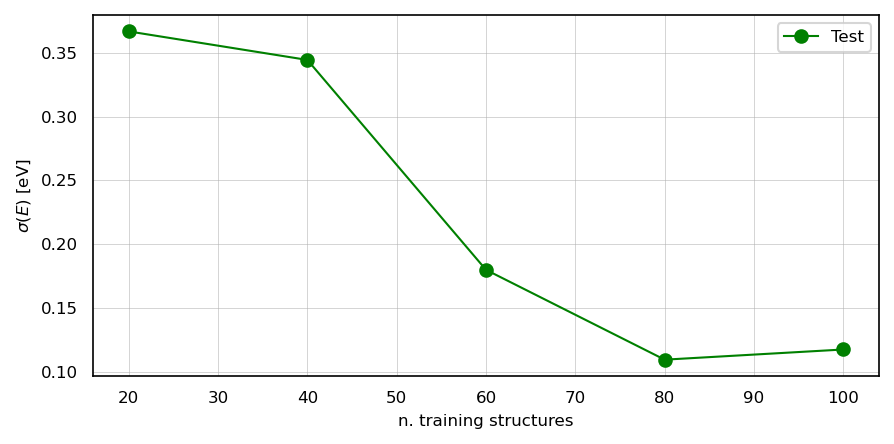

In [11]:
n_training_structures   = np.arange(n_init_train,n_iter_qbc*n_add_iter+n_init_train,n_add_iter)

fig, ax = plt.subplots(figsize=(6, 3))  # 1 row, 2 columns

# --- First plot: Test ---
ax.plot(n_training_structures, disagreement_mean, '-o', label='Test', color="green")
#ax.fill_between(n_training_structures,disagreement_mean-disagreement_std,disagreement_mean+disagreement_std,color="blue",alpha=0.2,linewidth=0)

ax.legend()
ax.set_xlabel('n. training structures')
ax.set_ylabel(r'$\sigma(E)$ [eV]')
# axs[0].set_title(r"Selected $\sigma(E)$")
plt.tight_layout()
plt.show()

In [12]:
print(predictions[0][0].arrays.keys())
print(predictions[0][0].info.keys())

TypeError: 'NoneType' object is not subscriptable

In [13]:
df = pd.DataFrame(columns=["iter","E-dis","F-dis","E-rmse","F-rmse"])
for file in glob.glob(f"{qbc_folder}/eval/test.*"):
    # print(file)
    match = re.search(r'model=(\d+)\.iter=(\d+)', file)
    model_num = int(match.group(1))
    iter_num = int(match.group(2))

# Run Molecular Dynamics

## Run FHI-aims

In [ ]:
from myfunctions import run_aims

In [ ]:
to_run  = structures[:4]

In [ ]:
%%capture
run_aims(
    structures=to_run,
    folder='aims',
    command=f"mpirun -n 4 /home/stoccoel/codes/FHIaims-polarization/build/polarization-debug/aims.250131.scalapack.mpi.x",
    control="../aims/control.in"
)